## Configuration

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, init_prophet_model, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

from src.scraping import update_e_mix_data, update_e_price_data, fetch_historical
from src.benchmark import extend_by_predictions_and_samples

In [3]:
# update_e_price_data()
# update_e_mix_data()
# fetch_historical()
# 

In [4]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 1), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [5]:
merged_df, e_price_df = get_datasets(prediction_date_picker.value)

Loading E-Prices
Last E-Price from: 2025-02-01 23:00:00
                      Price
Datetime                   
2018-10-01 00:00:00   59.53
2018-10-01 01:00:00   56.10
2018-10-01 02:00:00   51.41
2018-10-01 03:00:00   47.38
2018-10-01 04:00:00   47.59
...                     ...
2025-02-01 19:00:00  162.98
2025-02-01 20:00:00  156.60
2025-02-01 21:00:00  145.24
2025-02-01 22:00:00  141.73
2025-02-01 23:00:00  131.74

[55554 rows x 1 columns]
-----------------
Last energy mix from: 2025-02-01 00:00:00
                     Biomass  Hard Coal  Hydro  Lignite  Natural Gas  Nuclear   
Datetime                                                                        
2018-01-01 00:00:00    5.299      1.443  2.332    7.059        7.019    5.881  \
2018-01-01 01:00:00    5.283      1.425  2.191    7.149        7.108    4.776   
2018-01-01 02:00:00    5.285      1.485  2.186    7.103        7.164    4.612   
2018-01-01 03:00:00    5.290      1.469  2.168    7.059        7.267    4.911   
2018-01-

In [6]:
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,59.53,5.319,8.294,1.166,15.866,8.697,7.929,2.309,0.194,0.0,1.650,4.372,9.660435,0.004348,17.720478,0.0
2018-10-01 01:00:00,56.10,5.284,7.975,1.131,15.927,8.787,7.941,2.341,0.194,0.0,2.115,4.080,9.375652,0.047826,16.909334,0.0
2018-10-01 02:00:00,51.41,5.291,7.797,1.118,16.009,9.019,7.962,2.336,0.194,0.0,2.176,3.995,9.129999,0.052174,18.927275,0.0
2018-10-01 03:00:00,47.38,5.279,8.214,1.128,16.078,8.605,7.871,2.329,0.194,0.0,2.234,4.268,8.856087,0.073913,19.802275,0.0
2018-10-01 04:00:00,47.59,5.293,8.523,1.127,16.139,8.373,7.895,2.339,0.194,0.0,2.600,4.722,8.758261,0.113043,20.606785,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29 20:00:00,131.95,4.789,5.594,1.952,10.232,14.189,0.000,2.756,0.667,0.0,5.415,20.866,4.821304,0.021739,21.071400,0.0
2025-01-29 21:00:00,119.65,4.775,5.280,1.961,9.779,13.636,0.000,2.729,0.196,0.0,5.575,20.033,4.651739,0.043478,20.959840,0.0
2025-01-29 22:00:00,111.99,4.751,5.196,1.969,9.517,13.169,0.000,2.733,0.181,0.0,5.293,18.440,4.438696,0.160870,20.414845,0.0
2025-01-29 23:00:00,99.33,4.752,4.902,1.954,9.928,12.077,0.000,2.731,0.068,0.0,5.153,17.773,4.308261,0.204348,19.688711,0.0


## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [7]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [8]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



2024-12-30
2024-12-30


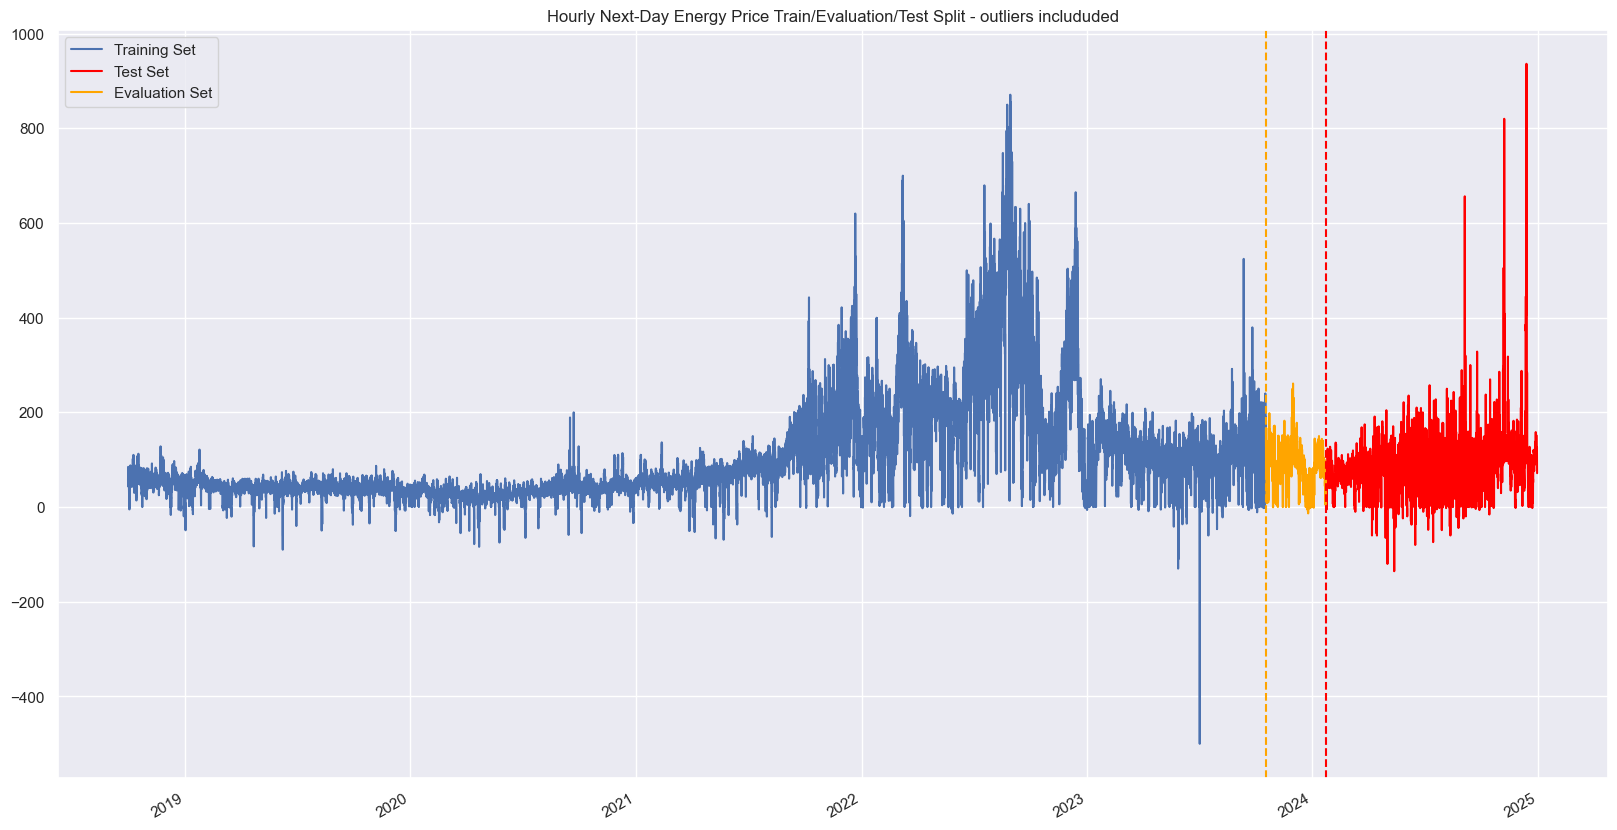

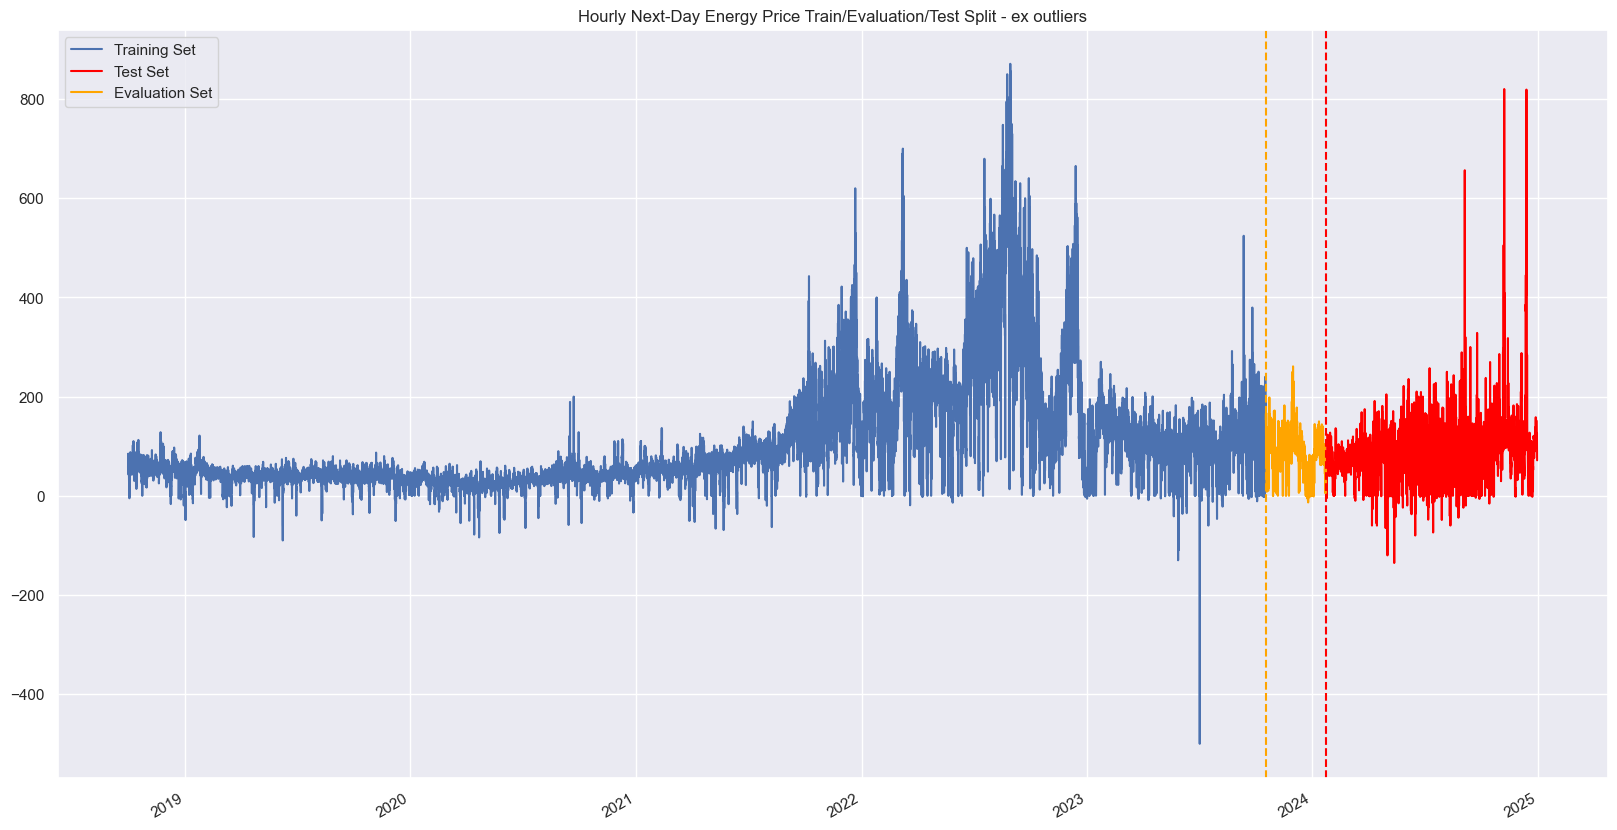

In [9]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [10]:
# lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
# lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [11]:
# best_params = {
#     "base_score": 0.380924762889507,
#     "early_stopping_rounds": 215,
#     "max_depth": 80,
#     "learning_rate": 0.06,
#     "n_estimators": 150,
#     "gamma": 0.9,
#     "min_child_weight": 6,
#     "subsample": 0.5719023844219375,
#     "colsample_bytree": 0.8815691043681952,
# }
# xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
# xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


### Prophet

In [12]:
# # Initialize Prophet model
# model = Prophet(
#     changepoint_prior_scale = 0.5,
#     seasonality_prior_scale = 1.0,
#     holidays_prior_scale = 1.0,
#     seasonality_mode= 'multiplicative'
# )

# #Add fourier order for weekly and monthly seasonality
# model.add_seasonality(name='weekly', period=7, fourier_order=20)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
# model.add_seasonality(name='yearly', period=365, fourier_order=20)

# # Add time-based regressors

# for feature in FEATURES:
#      model.add_regressor(feature)
     
# train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

# model.fit(train_data)

# test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
# test_data_prophet.drop(columns=["Price"])
# prophet_predictions = model.predict(test_data_prophet)["yhat"]


## Results

### Errors

In [13]:
# calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

### Plots

In [14]:
# # predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

# plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

In [15]:
# feature_importance(xgb_mse, "MSE")
# feature_importance(xgb_mae, "MAE")

## Prediction

In [ ]:
last_month = 24 * 31
window = 24
benchmarking_set = combined_df.iloc[-last_month:].copy()
cols = ["Price", "Hydro", "Pumped storage generation","Solar","Wind offshore","Wind onshore","temperature_2m","precipitation","wind_speed_100m","direct_radiation"]
FINAL_FEATURES =[
        "hour",
        "dayofyear",
        "dayofweek",
        "ma_2_hours",
        "ma_3_hours",
        "ma_4_hours",
        "ma_5_hours",
        "ma_6_hours",
        "ma_7_hours",
        "ma_8_hours",
        "ma_9_hours",
        "ma_10_hours",
        "ma_11_hours",
        "ma_12_hours",
        "ma_13_hours",
        "ma_14_hours",
        "ma_15_hours",
        "ma_16_hours",
        "ma_17_hours",
        "ma_18_hours",
        "ma_19_hours",
        "ma_20_hours",
        "ma_21_hours",
        "ma_22_hours",
        "ma_23_hours",
        "ma_1_days",
        "ma_3_days",
        "ma_7_days",
        "Hydro",
        "Pumped storage generation",
        "ma_3_hours_pumped_storage_generation",
        "ma_6_hours_pumped_storage_generation",
        "Solar",
        "Wind offshore",
        "Wind onshore",
        "temperature_2m",
        "precipitation",
        "wind_speed_100m",
        "direct_radiation"]

window = 24

training_set = merged_df.iloc[:-last_month][cols]
benchmark_df = merged_df.iloc[-last_month:][cols]


for i in range(0, len(benchmarking_set) - window, window):
    
    model = init_prophet_model([*FINAL_FEATURES])
    
    y_t = benchmarking_set.copy().iloc[i:i+window]["Price"]
    train_ex = pd.concat((training_set.copy(), benchmarking_set.copy().iloc[0:i]))

    train_and_pred = extend_by_predictions_and_samples(train_ex, train_ex.index[-1])
    train_and_pred_feat = create_features(train_and_pred.copy())

    X_benchmark = train_and_pred_feat.iloc[-window:][FINAL_FEATURES]
    X_benchmark = X_benchmark.reset_index().rename(columns={"index": "ds"})

    # print(X_benchmark)
    
    FEATURES = ["Price", *FINAL_FEATURES]
    X_train = train_and_pred_feat.iloc[:-window][FEATURES]
    X_train = X_train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

#     print(X_train)

    model.fit(X_train)

    print(f"Prediction from {train_ex.index[-1]} - {train_ex.index[-1] + timedelta(hours=window)}")
    predictions = model.predict(X_benchmark)["yhat"]

    rmse = mean_squared_error(y_t, predictions) ** 0.5
    print(rmse, "\n")
    
    


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54763 entries, 2018-10-01 00:00:00 to 2024-12-30 00:00:00
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Price                      54763 non-null  float64
 1   Hydro                      54763 non-null  float64
 2   Pumped storage generation  54763 non-null  float64
 3   Solar                      54763 non-null  float64
 4   Wind offshore              54763 non-null  float64
 5   Wind onshore               54763 non-null  float64
 6   temperature_2m             54763 non-null  float64
 7   precipitation              54763 non-null  float64
 8   wind_speed_100m            54763 non-null  float64
 9   direct_radiation           54763 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB
Training Set Info
--------------------------------------------------
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 20

17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2024-12-30 00:00:00 - 2024-12-31 00:00:00
RMSE
--------------------------------------------------
26.85620255283232

Iteration 2: Processing 24 to 48
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54787 entries, 2018-10-01 00:00:00 to 2024-12-31 00:00:00
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Price                                 54787 non-null  float64
 1   Hydro                                 54787 non-null  float64
 2   Pumped storage generation             54787 non-null  float64
 3   Solar                                 54787 non-null  float64
 4   Wind offshore                         54787 non-null  float64
 5   Wind onshore                          54787 non-null  float64
 6   temperature_2m                        54787 non-null  float64
 7   precipitation                         54787 non-null  float64
 8   wind_speed_100m

17:57:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:37 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2024-12-31 00:00:00 - 2025-01-01 00:00:00
RMSE
--------------------------------------------------
24.469285291298533

Iteration 3: Processing 48 to 72
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54811 entries, 2018-10-01 00:00:00 to 2025-01-01 00:00:00
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Price                                 54811 non-null  float64
 1   Hydro                                 54811 non-null  float64
 2   Pumped storage generation             54811 non-null  float64
 3   Solar                                 54811 non-null  float64
 4   Wind offshore                         54811 non-null  float64
 5   Wind onshore                          54811 non-null  float64
 6   temperature_2m                        54811 non-null  float64
 7   precipitation                         54811 non-null  float64
 8   wind_speed_100

17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-01 00:00:00 - 2025-01-02 00:00:00
RMSE
--------------------------------------------------
66.1865501933814

Iteration 4: Processing 72 to 96
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54835 entries, 2018-10-01 00:00:00 to 2025-01-02 00:00:00
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Price                                 54835 non-null  float64
 1   Hydro                                 54835 non-null  float64
 2   Pumped storage generation             54835 non-null  float64
 3   Solar                                 54835 non-null  float64
 4   Wind offshore                         54835 non-null  float64
 5   Wind onshore                          54835 non-null  float64
 6   temperature_2m                        54835 non-null  float64
 7   precipitation                         54835 non-null  float64
 8   wind_speed_100m 